<a href="https://colab.research.google.com/github/murtazav/Model_predictive_control/blob/master/Parameter_finder_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# best controller parameterfinder using genetic algorithm
import numpy as np
import random
from matplotlib import pyplot as plt

population = 20
kp_arr = np.zeros(population)
ki_arr = np.zeros(population)
fit_arr = np.zeros(population)
kp_max = 100.0
kp_min = 0.0
ki_max = 100.0
ki_min = 0.0
itr = 50



In [0]:
#environment with bicycle model which returns fitness of a controller
def envm(kp, ki):
  mfl=158  # mass at front left wheel
  mfr=137  # mass at front right wheel
  mrl=360  # mass at rear left wheel
  mrr=269  # mass at front right wh

  m = 924  #mass of the vehicle

  lf= 1.31  # location of centre of gravity from the front axle
  lr=0.62   # location of centre of gravity from the rear axle
  Iz=748    # moment of inertia
  l=lf+lr

  V=1
  #cornering stiffness of tyre
  Cf=27359
  Cr=58535
  dt=0.001
  tf=10
  vy = np.zeros(15000)
  vy_dot = np.zeros(15000)
  delt_4 = np.zeros(15000) 
  theta_dot = np.zeros(15000)
  theta_4 = np.zeros(15000)
  theta_des = np.zeros(15000)
  theta_ddot = np.zeros(15000)
  e = np.zeros(15000)
  e_int = np.zeros(15000)
  fitness =0
  time = np.zeros(15000)
  for i in range(1,len(time)):
    time[i] = time[i-1]+dt
  i=1
  for t in time[0:10000]:
    if i>=1000:
      theta_des[i]=0.349

    e[i] = (theta_des[i]-theta_4[i-1])
    fitness = fitness - np.power(t,2)*np.absolute(e[i])*dt
    e_int[i] = e_int[i-1]+e[i]*0.001
    delt_4[i]=kp*e[i]+ki*e_int[i]

    vy_dot[i]=-V*theta_dot[i-1]+1/m*(Cr*(-np.arctan((vy[i-1]-lr*theta_dot[i-1])/V))+Cf*(delt_4[i]-np.arctan((vy[i-1]+lf*theta_dot[i-1])/V))*np.cos(delt_4[i]))
    theta_ddot[i]=1/Iz*(Cr*lr*(-np.arctan((vy[i-1]-lr*theta_dot[i-1])/V))+Cf*(delt_4[i]-np.arctan((vy[i-1]+lf*theta_dot[i-1])/V))*np.cos(delt_4[i])*lf)

    theta_dot[i] = theta_ddot[i]*dt +theta_dot[i-1]
    theta_4[i] = theta_dot[i]*dt+theta_4[i-1]
    vy[i] = vy_dot[i]*dt+vy[i-1]
    i = i+1 
    #print(fitness)
  plt.plot(time[0:10000],theta_4[0:10000]*180/np.pi)
  plt.plot(time[0:10000],theta_des[0:10000]*180/np.pi)
  
  plt.plot(time[0:10000],delt_4[0:10000]*180/np.pi)
  plt.legend(['heading_angle','desired heading','steering angle'])
  plt.xlabel('time in s')
  plt.ylabel('Angle in degrees')
  # linearly penalizing max steering angle, max overshoot, randomly improving fitness with mean 5 and std 5 to introduce luck in evolution process
  fitness = 10*fitness - 50*np.amax(delt_4[0:10000]) -100*(np.amax(theta_4[0:10000])-np.amax(theta_des[0:10000])) + (np.random.randn()*5+5)
  return fitness



-44.8972128477336

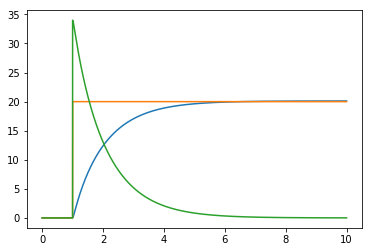

In [3]:
envm(1.7,0.01)

In [0]:
# to randomly generate a contorller within the range
def random_birth(kp_arr, ki_arr):
  for i in range(population):
    kp_arr[i] = random.uniform(kp_min, kp_max)
    ki_arr[i]= random.uniform(ki_max, kp_min)
  return kp_arr, ki_arr

# to generate offspring from the best parents with added mutation
def offspring(kp_mean, kp_std, ki_mean, ki_std):
  kp = np.absolute(np.random.randn()*kp_mean +kp_std)
  ki = np.absolute(np.random.randn()*ki_mean + ki_std)

  #mutation 
  if random.random() < 0.1 :
    kp = np.absolute(kp + 0.1*(np.random.randn()*kp_mean+kp_std))
    ki = np.absolute(ki + 0.1*(np.random.randn()*ki_mean+ki_std))
  return kp, ki
	



In [0]:
# to iteratively create and delete generations to reach the generaton with best fitness score
def iterations(kp_arr, ki_arr, fit_arr):
  for i in range(itr):
    for j in range(population):
      fit_arr[j] = envm(kp_arr[j], ki_arr[j])

    # sort remove the half controllers with worst fitness
    sorted_index = np.argsort(fit_arr)
    kp_arr = kp_arr[sorted_index]
    ki_arr = ki_arr[sorted_index]
    fit_arr = fit_arr[sorted_index]
    print(str(kp_arr[-1])+'  '+str(ki_arr[-1])+'  '+str(fit_arr[-1]))
    # generate offsprings with the best four controllers

    kp_mean = np.average(kp_arr[int(population/2):population])
    kp_std = np.std(kp_arr[int(population/2):population])
    ki_mean = np.average(ki_arr[int(population/2):population])
    ki_std = np.std(ki_arr[int(population/2):population])
    for j in range(int(population/2)):
      kp_arr[j], ki_arr[j] = offspring(kp_mean, kp_std, ki_mean, ki_std)
   
  return kp_arr, ki_arr, fit_arr

In [6]:
a=np.array([1,33,455,67,0,8])
a[np.argsort(a)]

array([  0,   1,   8,  33,  67, 455])

In [0]:
kp_arr, ki_arr = random_birth(kp_arr, ki_arr)


12.65734472764155  10.56366158976607  -397.5202547604484
16.353269712106233  85.06874402982606  -298.9246901102163
16.353269712106233  85.06874402982606  -293.7510487273651
1.021016794251242  0.16244902270978656  -183.88179903304268
1.021016794251242  0.16244902270978656  -178.77769617147825
1.021016794251242  0.16244902270978656  -171.92656712430536
1.021016794251242  0.16244902270978656  -174.76841377289625
2.582663640350369  16.955245123992675  -116.1736466292108
2.582663640350369  16.955245123992675  -110.97846077448727
2.582663640350369  16.955245123992675  -111.47812643140004
3.040824477599672  14.182609223555046  -105.88895877682
2.111002814016632  7.375403460079987  -88.71616368336139
2.111002814016632  7.375403460079987  -85.40617984296124
2.111002814016632  7.375403460079987  -84.67126347500688
3.4372187970040007  4.676743738930856  -75.7716799380238
3.4372187970040007  4.676743738930856  -68.34613062250534
3.19993091837277  4.850020675820452  -73.0482101879686
3.199930918372

(array([0.01958531, 1.85968749, 0.22083999, 0.26752454, 1.85259656,
        0.33427676, 0.03729085, 0.53865095, 2.71445416, 1.19430442,
        2.98312083, 3.40181986, 2.82077566, 2.30260842, 2.90689502,
        2.45718795, 2.84578644, 1.97381699, 3.10009455, 2.66004196]),
 array([3.40843857, 2.29176214, 4.63705571, 4.91467646, 0.8738723 ,
        1.39018066, 1.81872286, 2.43514584, 1.62780086, 2.43593983,
        1.59252171, 4.57550186, 3.73097147, 3.91717224, 5.31744289,
        3.44419341, 3.29692057, 0.05741038, 2.79328475, 0.05661888]),
 array([-1.96320007e+06, -9.18067630e+02, -5.90966052e+02, -1.70276898e+02,
        -1.13494518e+02, -1.00681176e+02, -8.55317022e+01, -8.25185796e+01,
        -8.14084882e+01, -7.75154127e+01, -7.73754588e+01, -7.55063109e+01,
        -7.34289116e+01, -7.26495095e+01, -6.77488998e+01, -6.53747976e+01,
        -6.36225177e+01, -6.07322756e+01, -5.91125895e+01, -5.86262297e+01]))

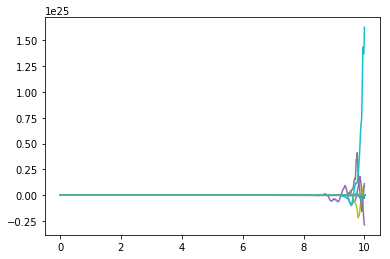

In [11]:
iterations(kp_arr, ki_arr, fit_arr)

-65.29305671949302

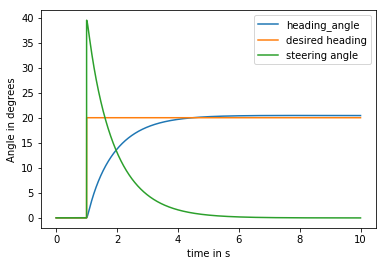

In [22]:
envm(1.97381,0.0574)


-61.2860194434187

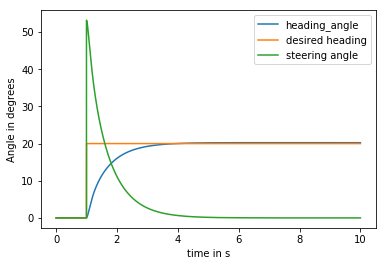

In [23]:
envm(2.66,0.0566)


-77.58339488653164

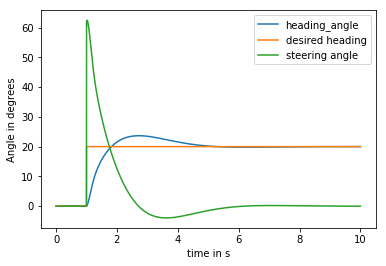

In [24]:
envm(3.1,2.79)